In [1]:
import pandas as pd
df = pd.read_csv('tep_trainset_seed10_2.csv',index_col=0).reset_index(drop=True)
print(df.shape)
df.head()

(7581, 41)


,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_6,xmeas_8,xmeas_9,...,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_9,xmv_10,xmv_11
0,0,262,262,0.21906,3644.9,4564.0,9.4741,41.925,74.876,120.39,...,44.029,63.307,53.692,21.260,61.646,22.850,43.093,48.886,40.885,18.519
1,0,262,286,0.25735,3633.6,4550.2,9.2276,42.333,74.858,120.43,...,42.472,62.317,53.419,25.093,62.136,22.746,35.574,46.437,41.294,17.145
2,0,262,295,0.24069,3661.4,4474.5,9.3000,42.275,75.300,120.40,...,44.543,62.770,53.868,23.666,59.950,22.253,42.108,46.417,41.021,17.702
3,0,262,318,0.23227,3717.0,4476.5,9.2779,42.153,74.947,120.38,...,44.629,64.116,54.029,23.084,58.714,21.563,40.654,46.466,41.257,18.055
4,0,262,323,0.25705,3666.4,4454.8,9.3565,42.511,74.656,120.40,...,43.427,63.083,53.651,25.561,59.252,21.554,39.992,45.993,40.942,21.179


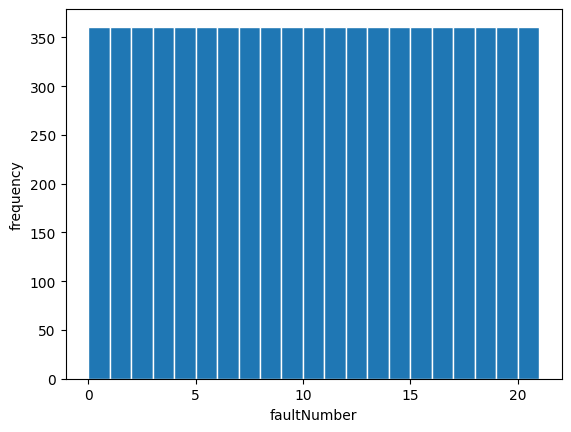

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(df['faultNumber'],edgecolor='w',bins=range(22))
plt.xlabel('faultNumber')
plt.ylabel('frequency')
plt.show()

In [3]:
# split the df into data (for training) and target
data = df.iloc[:,3:].to_numpy()
target = df['faultNumber'].to_numpy()

In [4]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split
# train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=42)
print(train_input.shape, test_input.shape)

(6064, 38) (1517, 38)


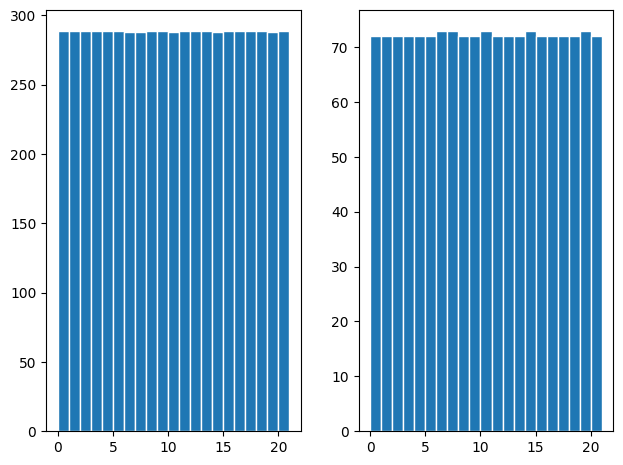

In [5]:
fig, axs = plt.subplots(1,2)
fig.tight_layout()
axs[0].hist(train_target, edgecolor='w', bins=range(0,22))
axs[1].hist(test_target, edgecolor='w', bins=range(0,22))
plt.show()

In [6]:
# scaling - which is not required for tree models..
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
mm.fit(train_input)
train_scaled = mm.transform(train_input)
test_scaled = mm.transform(test_input)

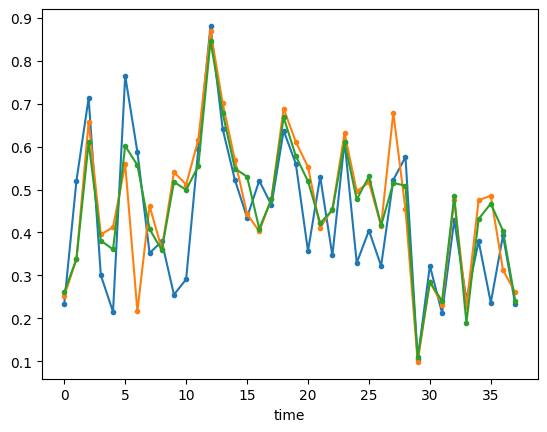

In [7]:
plt.plot(train_scaled[0], '.-')
plt.plot(train_scaled[100], '.-')
plt.plot(train_scaled[200], '.-')
plt.xlabel('time')
plt.show()

In [8]:
# ML classification models
# 1. decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target), dt.score(test_scaled, test_target))
test_predicted = dt.predict(test_scaled)

from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(test_target, test_predicted)
print(accuracy)

1.0 0.6196440342781806
0.6196440342781806


In [ ]:
# highly overfitted

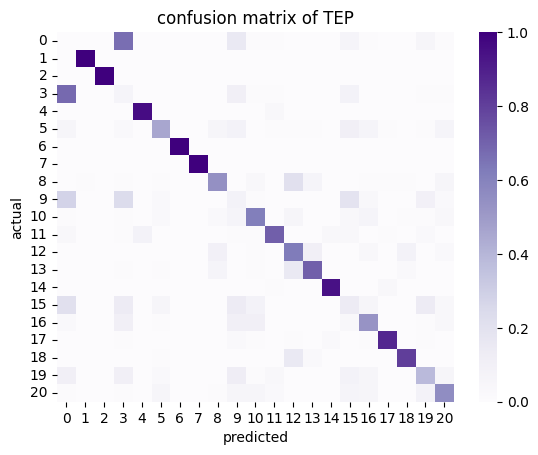

In [9]:
cm = confusion_matrix(test_target, test_predicted, normalize='true')
ax = sns.heatmap(cm, annot=False, cmap='Purples')
ax.set(xlabel='predicted', ylabel='actual', title='confusion matrix of TEP')
plt.show()

In [10]:
# 2. RandomForest
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_scaled, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

rf.fit(train_input, train_target)
print(rf.feature_importances_)
print(len(rf.feature_importances_))

1.0 0.6500651631527539
[0.03686718 0.01109263 0.01493152 0.02626684 0.01450819 0.01390192
 0.03965108 0.02542443 0.02970314 0.03372601 0.03886302 0.02889388
 0.0617201  0.02468998 0.02222871 0.01248833 0.0229709  0.0139161
 0.02265934 0.02386175 0.01395794 0.02176894 0.01688352 0.02767912
 0.01798177 0.01603144 0.02330739 0.01219239 0.0114355  0.01123059
 0.01366914 0.03584539 0.05757782 0.03502784 0.02781291 0.031542
 0.07680981 0.03088145]
38


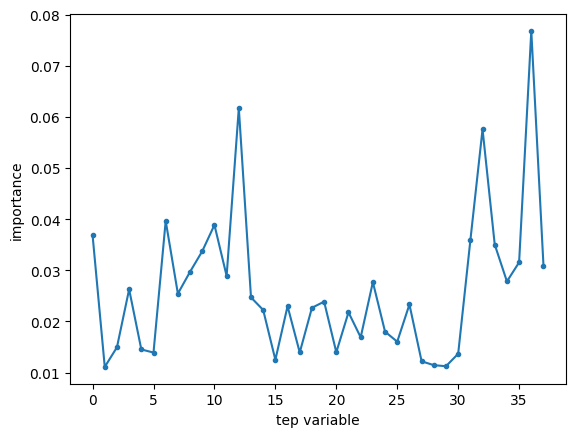

In [11]:
plt.plot(rf.feature_importances_, '.-')
plt.xlabel('tep variable')
plt.ylabel('importance')
plt.show()

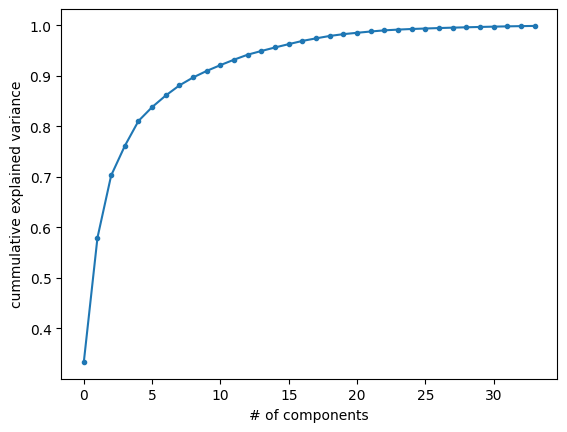

In [12]:
# combined with pca
from sklearn.decomposition import PCA
pca = PCA(n_components=34)
pca.fit(train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.-')
plt.xlabel('# of components')
plt.ylabel('cummulative explained variance')
plt.show()

In [13]:
# will go with n_components=10
pca = PCA(n_components=15)
pca.fit(train_scaled)
tep_pca = pca.transform(train_scaled)

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, tep_pca, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

1.0 0.538917230552404


It rather worsens the score; so forget about this combination and try other classification models 😂 Better apply PCA to the original set of variables

In [14]:
# 3. extraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_scaled, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

1.0 0.6535279249276946


In [15]:
# 4. gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_scaled, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9710998641631076 0.679419190888586


In [16]:
# 5. XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
scores = cross_validate(xgb, train_scaled, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

1.0 0.6698534033123016


In [17]:
# 6. LightGBM
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_scaled, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

1.0 0.6804079294986382
